# Bayes Classifier and Boosting

In [1]:
## Import the libraries

In [16]:
import numpy as np
from scipy import misc
from importlib import reload
from bayesfuns import *
import random

## Bayes classifier functions

In [24]:
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)
    
    prior = np.array([ len(labels[labels==k])/Npts for k in classes])
    
    return prior # The prior probability of a point belonging to class k


# in:      X       - N x d matrix of N data points
#        labels    - N vector of class labels
#
# out:    mu       - C x d matrix of class means (mu[i] - class i mean)
#       sigma      - C x d x d matrix of class covariances (sigma[i] - class i sigma)
#
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts, Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: compute mu and sigma
    for k in classes:      
        # sum the rows of X which correspond to class k, divide by the number of classes
        mu[k,:] = np.sum( X[labels == k] ) / Nclasses 
        sigma[k,:,:] = np.sum([np.outer(x-mu[k,:], x-mu[k,:])/Nclasses for x in X[labels == k]], 0)
    
    return mu, sigma


# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
#
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses, Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))
    
    for k in range(Nclasses):
        logProb[k,:] = [ discriminantFun(x, prior[k] , mu[k,:], sigma[k,:,:]) for x in X]
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

# TODO: Dont use inverse, fix later
def discriminantFun(x, pk, mu, sigma):
    return -0.5*( np.log(np.linalg.det(sigma) + np.dot( (x-mu), np.dot(np.linalg.inv(sigma), np.transpose(x))))) + np.log(pk)


The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [25]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

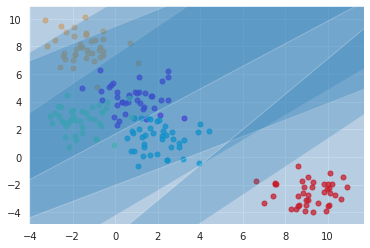

In [26]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [27]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 33.3
Trial: 10 Accuracy 33.3
Trial: 20 Accuracy 33.3
Trial: 30 Accuracy 33.3
Trial: 40 Accuracy 33.3
Trial: 50 Accuracy 33.3
Trial: 60 Accuracy 33.3
Trial: 70 Accuracy 33.3
Trial: 80 Accuracy 33.3
Trial: 90 Accuracy 33.3
Final mean classification accuracy  33.3 with standard deviation 0


In [28]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

/home/marcus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log


Trial: 0 Accuracy 15.6
Trial: 10 Accuracy 22.1
Trial: 20 Accuracy 20.1
Trial: 30 Accuracy 27.3
Trial: 40 Accuracy 24.7
Trial: 50 Accuracy 26.6
Trial: 60 Accuracy 27.3
Trial: 70 Accuracy 14.3
Trial: 80 Accuracy 26.6
Trial: 90 Accuracy 23.4
Final mean classification accuracy  21.9 with standard deviation 4.83


/home/marcus/Documents/KTH/MachineLearning-DD2421/bayes/bayesfuns.py:251: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D

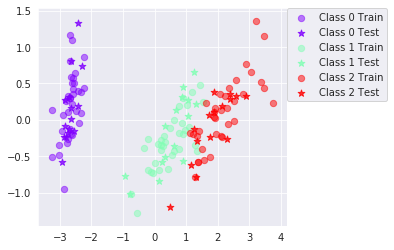

In [29]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [ ]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        
        # alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [ ]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])